In [61]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

In [2]:
data_path = '../data/preprocessed_data_2010_2025.csv'

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.head()

,Datetime,Temperature,Wind Speed,Condition_Blowing Sand,Condition_Cloudy,Condition_Drizzle,Condition_Duststorm,Condition_Fair,Condition_Fog,Condition_Freezing Rain,...,Condition_Small Hail,Condition_Smoke,Condition_Snow,Condition_Snow Grains,Condition_Squalls,Condition_Thunder,Condition_Widespread Dust,Condition_Wintry Mix,WindDir_sin,WindDir_cos
0,2010-01-01 00:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.866025,-4.999999e-01
1,2010-01-01 01:00:00,10.000000,6.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-1.000000,1.192488e-08
2,2010-01-01 02:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01
3,2010-01-01 03:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01
4,2010-01-01 04:00:00,11.111111,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01


In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime')
df = df.set_index('Datetime')

In [6]:
target = [t for t in df.columns if t.startswith('Condition_')]
features = df.columns

In [7]:
split_date = '2022-1-1'
train_df = df.loc[:split_date]
test_df = df.loc[split_date:]

In [8]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [9]:
X_train = X_scaler.fit_transform(train_df[features])
X_test = X_scaler.transform(test_df[features])

In [10]:
y_train = y_scaler.fit_transform(train_df[target])
y_test = y_scaler.transform(test_df[target])

In [11]:
WINDOW = 24 * 3

In [12]:
def make_sequence(X, y, window=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])

    return np.array(X_seq), np.array(y_seq)

In [13]:
X_train_seq, y_train_seq = make_sequence(X_train, y_train, window=WINDOW)

In [14]:
X_test_seq, y_test_seq = make_sequence(X_test, y_test, window=WINDOW)

In [15]:
model = Sequential([
    Input(shape=(X_test_seq.shape[1],X_test_seq.shape[2])),
    LSTM(64,activation='tanh'),
    Dense(y_test_seq.shape[1], activation='softmax')
])

In [16]:
model.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(),
    metrics=['categorical_accuracy',
            'precision',
            'recall']
)

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [18]:
model_checkpoint = ModelCheckpoint(
    '../models/lstm_conditions_best_model_full.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

In [19]:
model.fit(X_train_seq,
          y_train_seq,
         validation_split=0.1,
         epochs=25,
         batch_size=32,
         callbacks=[model_checkpoint, early_stopping])

Epoch 1/25


2025-12-28 14:34:28.022328: I external/local_xla/xla/service/service.cc:163] XLA service 0x76947800ad70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-12-28 14:34:28.022364: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-12-28 14:34:28.118378: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


   7/2929 ━━━━━━━━━━━━━━━━━━━━ 57s 20ms/step - categorical_accuracy: 0.2006 - loss: 3.3004 - precision: 0.0000e+00 - recall: 0.0000e+00 

I0000 00:00:1766921668.988090   10251 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2929/2929 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - categorical_accuracy: 0.8372 - loss: 0.5706 - precision: 0.8782 - recall: 0.8078 - val_categorical_accuracy: 0.8068 - val_loss: 0.7006 - val_precision: 0.8378 - val_recall: 0.7833
Epoch 2/25
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - categorical_accuracy: 0.8674 - loss: 0.4681 - precision: 0.8837 - recall: 0.8585 - val_categorical_accuracy: 0.8099 - val_loss: 0.6959 - val_precision: 0.8332 - val_recall: 0.7918
Epoch 3/25
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - categorical_accuracy: 0.8682 - loss: 0.4613 - precision: 0.8832 - recall: 0.8608 - val_categorical_accuracy: 0.8097 - val_loss: 0.6872 - val_precision: 0.8333 - val_recall: 0.7955
Epoch 4/25
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - categorical_accuracy: 0.8684 - loss: 0.4582 - precision: 0.8838 - recall: 0.8605 - val_categorical_accuracy: 0.8113 - val_loss: 0.6777 - val_precision: 0.8329 - val_recall: 0.7972
Epoch 5/25
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - c

In [20]:
y_pred_scaled = model.predict(X_test_seq)

1087/1087 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


In [43]:
y_prec = y_scaler.inverse_transform(y_pred_scaled)
y_pred = np.argmax(y_prec,axis=1)
y_pred_report = np.round(y_prec)
y_true_rescaled = y_scaler.inverse_transform(y_test_seq)
y_true = np.argmax(y_pred_scaled, axis=1)
y_true_report = np.round(y_pred_scaled)

In [44]:
cm = confusion_matrix(y_true,y_pred)

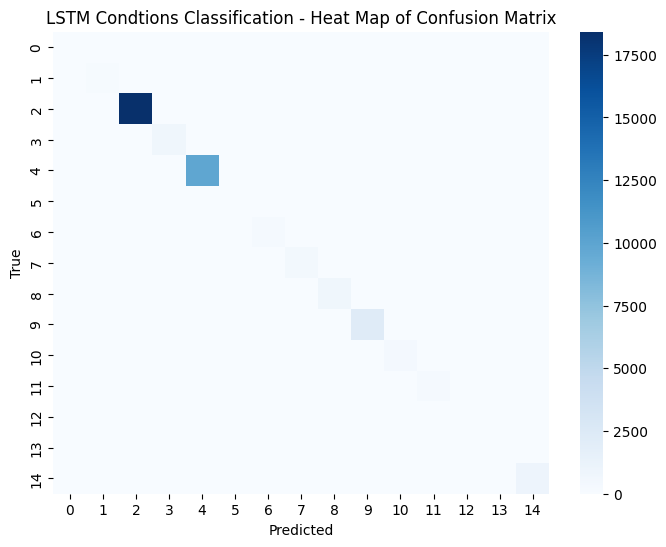

In [68]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, cmap='Blues')
plt.title('LSTM Condtions Classification - Heat Map of Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [62]:
precision = precision_score(y_true_report, y_pred_report,average='macro', zero_division=0)
recall = recall_score(y_true_report, y_pred_report,average='macro', zero_division=0)
f1_score_ = f1_score(y_true_report, y_pred_report,average='macro', zero_division=0)

In [64]:
print(f'{'Prefomance Metrics':-^30}')
print(f'{precision = }')
print(f'{recall    = }')
print(f'{f1_score_ = }')

------Prefomance Metrics------
precision = 0.4375
recall    = 0.4375
f1_score_ = 0.4375
